## Working with `ugropy`

### Failing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ipqa-research/ugropy/blob/main/docs/source/tutorial/ugropy_failing.ipynb)

`ugropy` may fail to obtain the subgroups of a molecule for a certain model for
two reasons: either there is a bug in the code, or the molecule cannot be
represented by the subgroups of the failing model.

`ugropy` utilizes SMARTS for the representation of functional groups to inquire
whether the molecule contains those structures. Let's examine the functional
group list for the classic liquid-vapor UNIFAC model.

In [1]:
try:
  import google.colab
  %pip install -q ugropy
except ImportError:
  pass

In [2]:
from ugropy import unifac

unifac.subgroups

,smarts,molecular_weight
group,,
CH3,[CX4H3],15.03500
CH2,[CX4H2],14.02700
CH,[CX4H],13.01900
C,[CX4H0],12.01100
CH2=CH,[CH2]=[CH],27.04600
...,...,...
NCO,[NX2H0]=[CX2H0]=[OX1H0],42.01700
(CH2)2SU,[CH2]S(=O)(=O)[CH2],92.11620
CH2CHSU,[CH2]S(=O)(=O)[CH],91.10840


For example, let's check the SMARTS representation of the alcohol group ACOH:

In [3]:
unifac.subgroups.loc["ACOH", "smarts"]

'[cH0][OH]'

The SMARTS representation it's telling us that the OH group it's, of course, a
hydroxyl group bounded by a single bound to an aromatic carbon atom.

An example of a molecule that cannot be represented by UNIFAC groups:

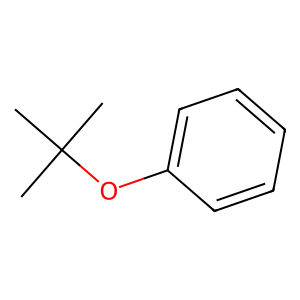

In [4]:
from rdkit.Chem import Draw


mol = unifac.get_groups("C1(=CC=CC=C1)OC(C)(C)C", "smiles")

Draw.MolToImage(mol.molecule)

In [5]:
print(mol.subgroups)

{}


The library "fails" to obtain any functional groups to accurately represent the
molecule. This failure is represented by an empty dictionary. In this case, the
"fail" is correct, but it could fail due to errors in the groups SMARTS
representations or the algorithm, resulting in an empty dictionary as well.
Currently, the supported models are tested against 444 different molecules.

If you encounter a failing representation, you can examine the structure of the
molecule and the list of functional groups of the failing model. If you
determine that the molecule can indeed be modeled, you may have discovered a
bug. Feel free to report the issue on the repository along with the failing
molecule's SMILES/name, the failing model and the `ugropy` version.

#### More than one solution
Models like UNIFAC or PSRK can have multiple solutions to represent a molecule,
and ugropy tries its best to find them all. In such cases, you will receive a
list of dictionaries, each containing one of the solutions found. Let's take a
look.

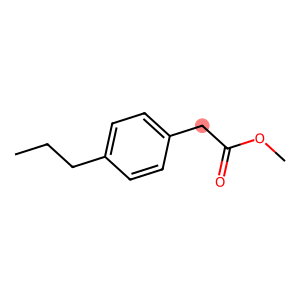

In [6]:
from ugropy import unifac
from rdkit.Chem import Draw


mol = unifac.get_groups("CCCC1=CC=C(CC(=O)OC)C=C1", "smiles", search_multiple_solutions=True)

Draw.MolToImage(mol[0].molecule, highlightAtoms=[7])

This molecule can be modeled in two ways depending on how we treat the CH2
attached to the ring and the ester carbon (highlighted in red). We can either
form an ACCH2 group and model the ester group with COO, or we can use an AC
group and model the ester group with CH2COO.

In [7]:
print("Solution 1:")
print(mol[0].subgroups)
print("solution 2:")
print(mol[1].subgroups)

Solution 1:
{'CH3': 2, 'CH2': 1, 'ACH': 4, 'ACCH2': 2, 'COO': 1}
solution 2:
{'CH3': 2, 'CH2': 1, 'ACH': 4, 'AC': 1, 'ACCH2': 1, 'CH2COO': 1}


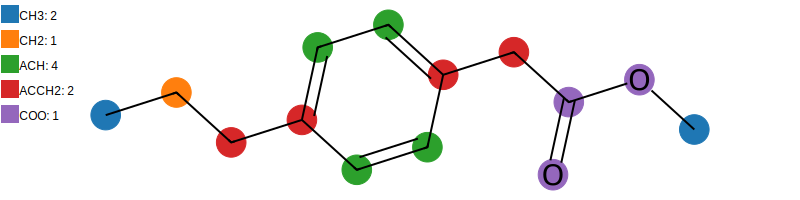

In [8]:
mol[0].draw(width=800)

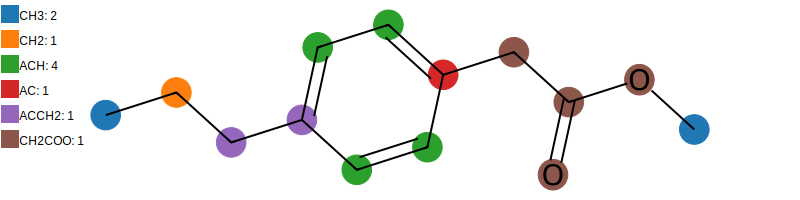

In [9]:
mol[1].draw(width=800)

This could be useful in cases where some groups have more interaction
parameters than others in the mixture that you want to model with UNIFAC.
Alternatively, you can try both approaches and compare if there are any
differences.

### More solutions (non-optimal)

`ugropy` allows you to search multiple solutions for the models, but all these
solutions are optimal (uses the same number of groups to represent the
molecule). It's possible to search for non-optimal solutions along with the
optimal ones. This is useful when the user wants to find all possible
combinations of fragments that cover the molecule. This feature is intended
for research purposes and is not recommended to actually model the molecules.

We can do this with the `search_nonoptimal` parameter:

In [10]:
from ugropy import unifac

solutions = unifac.get_groups(
    "9,10-dihydroanthracene",
    search_multiple_solutions=True, # If this is False, search_nonoptimal is ignored
    search_nonoptimal=True,
)

solutions

We can check all the obtained solutions:

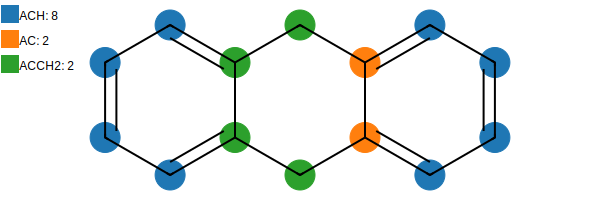

In [11]:
solutions[0].draw(width=600)

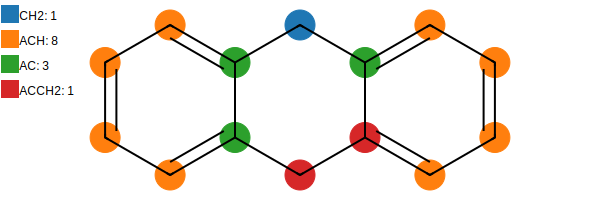

In [12]:
solutions[1].draw(width=600)

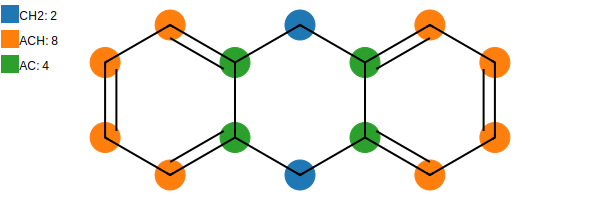

In [13]:
solutions[2].draw(width=600)

If you are an experienced user of UNIFAC-like models, you may notice that the
only "correct" solution is the first one. All `ugropy` models have the 
capacity to also search for non-optimal solutions.

### Models information

You can check information about the models' fragments. For example, the
UNIFAC, PSRK, and Dortmund models have the information about the R and Q 
values, the subgroup number, and main group number. you can access to this
information with `model`.subgroups_info:

In [14]:
from ugropy import unifac, psrk, dortmund


unifac.subgroups_info

,subgroup_number,main_group,R,Q
group,,,,
CH3,1,1,0.9011,0.848
CH2,2,1,0.6744,0.540
CH,3,1,0.4469,0.228
C,4,1,0.2195,0.000
CH2=CH,5,2,1.3454,1.176
...,...,...,...,...
NCO,109,51,1.0567,0.732
(CH2)2SU,118,55,2.6869,2.120
CH2CHSU,119,55,2.4595,1.808


Moreover, you can consult the fragments properties contributions of models
like Joback:

In [15]:
from ugropy import joback, abdulelah_gani

joback.properties_contributions

,Tc,Pc,Vc,Tb,Tf,Hform,Gform,a,b,c,d,Hfusion,Hvap,na,nb,num_of_atoms
group,,,,,,,,,,,,,,,,
-CH3,0.0141,-0.0012,65.0,23.58,-5.10,-76.45,-43.96,19.500,-0.00808,0.000153,-9.670000e-08,0.908,2.373,548.29,-1.719,4
-CH2-,0.0189,0.0000,56.0,22.88,11.27,-20.64,8.42,-0.909,0.09500,-0.000054,1.190000e-08,2.590,2.226,94.16,-0.199,3
>CH-,0.0164,0.0020,41.0,21.74,12.64,29.89,58.36,-23.000,0.20400,-0.000265,1.200000e-07,0.749,1.691,-322.15,1.187,2
>C<,0.0067,0.0043,27.0,18.25,46.43,82.23,116.02,-66.200,0.42700,-0.000641,3.010000e-07,-1.460,0.636,-573.56,2.307,1
=CH2,0.0113,-0.0028,56.0,18.18,-4.32,-9.63,3.77,23.600,-0.03810,0.000172,-1.030000e-07,-0.473,1.724,495.01,-1.539,3
=CH-,0.0129,-0.0006,46.0,24.96,8.73,37.97,48.53,-8.000,0.10500,-0.000096,3.560000e-08,2.691,2.205,82.28,-0.242,2
=C<,0.0117,0.0011,38.0,24.14,11.14,83.99,92.36,-28.100,0.20800,-0.000306,1.460000e-07,3.063,2.138,NaN,NaN,1
=C=,0.0026,0.0028,36.0,26.15,17.78,142.14,136.70,27.400,-0.05570,0.000101,-5.020000e-08,4.720,2.661,NaN,NaN,1
CH,0.0027,-0.0008,46.0,9.20,-11.18,79.30,77.71,24.500,-0.02710,0.000111,-6.780000e-08,2.322,1.155,NaN,NaN,2


From all fragmentation models you have all the RDKit mol objects of each 
fragment already instantiated on a dictionary. This could be helpful to
for calculations, multiple solution filtering, or visualization:

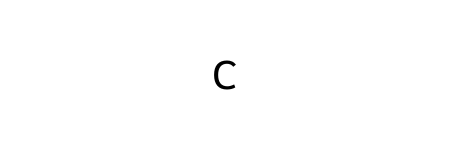

In [16]:
unifac.detection_mols["CH3"]

In [17]:
unifac.detection_mols["CH2O"].GetNumAtoms()

2

### Changing the default ILP solver

By default, `ugropy` uses the default CBC solver from the PulP library. But
PulP supports a lot of different solvers. An example could be de XPRESS_PY
solver.

First, you must install XPRESS with:

```shell
pip install xpress
```

Then you can change the default solver with a simple argument:

/opt/hostedtoolcache/Python/3.13.7/x64/lib/python3.13/site-packages/pulp/apis/xpress_api.py:751: LicenseWarning: Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/opt/hostedtoolcache/Python/3.13.7/x64/lib/python3.13/site-packages/xpress/license/community-xpauth.xpr')
  model = xpress.problem()


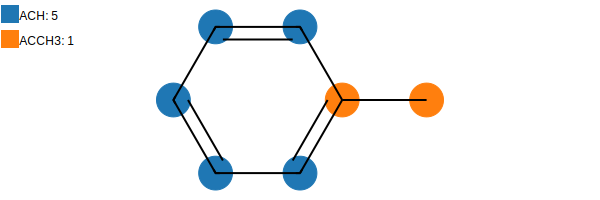

In [18]:
from ugropy import unifac


unifac.get_groups("toluene", solver_arguments={"solver": "XPRESS_PY"}).draw(width=600)

Changing the ILP solver has impact on the execution time of the library.